# remote setup as in szenario 3

running code locally, use tracking from remote

In [1]:
import mlflow
import os

os.environ["AWS_PROFILE"] = "default" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

In [2]:
TRACKING_SERVER_HOST = "ec2-18-132-211-111.eu-west-2.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

# get data

In [28]:
data_path = os.path.join(os.getcwd(), 'data_tmp')

In [29]:
!curl https://www.kaggle.com/datasets/ihelon/lego-minifigures-classification/download?datasetVersionNumber=30 lego_data.zip
!unzip lego_data.zip data_path
!rm lego_data.zip

OSError: [Errno 12] Cannot allocate memory

In [ ]:
# check if data present
!ls data_path

# test tracking with model training

In [3]:
import pandas as pd
import numpy as np
import torch
from fastai.vision.all import *
import random
from torchvision.models import resnet50, ResNet50_Weights

In [4]:
def seed_everything(seed=0):
    """ ensure reproducability by defining random seed """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [5]:
# TODO replace with aws s3?
os.environ['TORCH_HOME'] = 'models\\resnet' #setting the environment variable
path = os.path.join(os.getcwd(), 'data')  # path to downloaded dataset

In [6]:
def preprocess_data(df, metadata):
    """ add label column and change path to fname column"""
    df_lego = pd.merge(df, metadata['minifigure_name'], on='class_id')
    df_lego['labels'] = df_lego['minifigure_name'].apply(lambda x: x.lower())
    df_lego['fname'] = df_lego['path']
    return df_lego
    
def data_preprocess_handler(path):
    df = pd.read_csv(os.path.join(path, 'index.csv'), index_col=1)
    lego_metadata = pd.read_csv(os.path.join(path, 'metadata.csv'), index_col=0)
    df_lego = preprocess_data(df, lego_metadata)
    data = ImageDataLoaders.from_df(df_lego, path, valid_pct=0.10,
                                   item_tfms=Resize(412),
                                   bs=10, num_workers=0, label_col="labels")
    return data

In [10]:
df = pd.read_csv(os.path.join("/home/ubuntu/mlops_zoomcamp_homework/06_project/data", 'index.csv'), index_col=1)
lego_metadata = pd.read_csv(os.path.join("/home/ubuntu/mlops_zoomcamp_homework/06_project/data", 'metadata.csv'), index_col=0)
df_lego = preprocess_data(df, lego_metadata)

In [11]:
df_lego.columns.tolist()

['path', 'minifigure_name', 'labels', 'fname']

2022/08/29 18:45:26 INFO mlflow.tracking.fluent: Experiment with name 'project_resnet50_first' does not exist. Creating a new experiment.
/home/xydo/.virtualenvs/mlops_zoomcamp_homework-Pekz4x7C/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/xydo/.virtualenvs/mlops_zoomcamp_homework-Pekz4x7C/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.770149,2.111250,0.567568,0.432432,04:47
1,2.046118,1.430303,0.486486,0.513514,05:01
2,1.168672,1.177586,0.351351,0.648649,08:37
3,0.758115,1.312335,0.432432,0.567568,04:59
4,0.584969,1.865044,0.513514,0.486486,06:13


Better model found at epoch 0 with valid_loss value: 2.111250162124634.


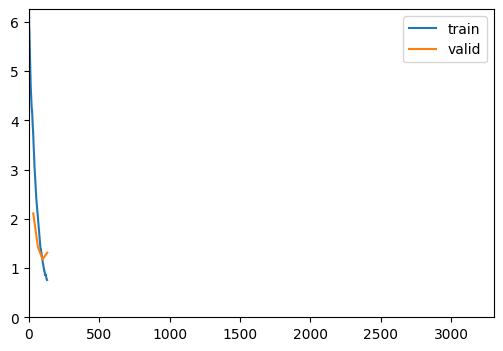

Better model found at epoch 1 with valid_loss value: 1.4303032159805298.
Better model found at epoch 2 with valid_loss value: 1.1775864362716675.
Epoch 3: reducing lr to 0.00098495277095499
Epoch 4: reducing lr to 0.0013060028959062395
No improvement since epoch 2: early stopping


2022/08/29 19:15:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp72idtu6k/model, flavor: fastai), fall back to return ['fastai==2.7.9']. Set logging level to DEBUG to see the full traceback.


In [27]:
mlflow.set_experiment("project_resnet50_first")


mlflow.fastai.autolog()
    
with mlflow.start_run():
    data = data_preprocess_handler(path)
    
    params = {"lr1": 1e-3, "lr2": 1e-1, "random_seed": 0}
    mlflow.log_params(params)
    
    resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
    learn = vision_learner(data, resnet50, metrics=[error_rate, accuracy], model_dir = Path(os.path.join(os.getcwd(),
                                                                                                   "models",
                                                                                                      "resnet")),
                       path =Path(""
                                                                                                                    "."))
    learn.fit_one_cycle(100, slice(params["lr1"],params["lr2"]),cbs=[EarlyStoppingCallback(patience=2),
                                                                    ShowGraphCallback(),
                                                SaveModelCallback(fname='model_best'),ReduceLROnPlateau()])

In [ ]:
cinterp = ClassificationInterpretation(learn, data)
cinterp = confusion_matrix()

In [18]:
mlflow.list_experiments()

[<Experiment: artifact_location='s3://mlflow-artifacts-remote-xydo/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-remote-xydo/1', experiment_id='1', lifecycle_stage='active', name='my-experiment-1', tags={}>]

# visualize outputs

In [ ]:
interp = interpretation.from_learner(learn)
# plot 5 best outputs
interp.plot_top_losses(5)


In [ ]:
# plot 5 worst outputs
interp.plot_top_losses(5, largest=False)

# use tracking server

In [19]:
from mlflow.tracking import MlflowClient


client = MlflowClient(f"http://{TRACKING_SERVER_HOST}:5000")

In [22]:
client.list_registered_models()

[<RegisteredModel: creation_timestamp=1661784690407, description='', last_updated_timestamp=1661784761990, latest_versions=[<ModelVersion: creation_timestamp=1661784690553, current_stage='Staging', description='', last_updated_timestamp=1661784761990, name='iris-classifier', run_id='bd5bc854d6d64534b820a7d13572457e', run_link='', source='s3://mlflow-artifacts-remote-xydo/1/bd5bc854d6d64534b820a7d13572457e/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>], name='iris-classifier', tags={}>]

In [21]:
run_id = client.list_run_infos(experiment_id='1')[0].run_id
mlflow.register_model(
    model_uri=f"runs:/{run_id}/models",
    name='iris-classifier'
)

Successfully registered model 'iris-classifier'.
2022/08/29 16:51:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: iris-classifier, version 1
Created version '1' of model 'iris-classifier'.


<ModelVersion: creation_timestamp=1661784690553, current_stage='None', description='', last_updated_timestamp=1661784690553, name='iris-classifier', run_id='bd5bc854d6d64534b820a7d13572457e', run_link='', source='s3://mlflow-artifacts-remote-xydo/1/bd5bc854d6d64534b820a7d13572457e/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>